<a href="https://colab.research.google.com/github/praveentn/hgwxx7/blob/master/datascience/Causality_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Copyright 2020 DeepMind Technologies Limited.
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> 
> You may obtain a copy of the License at
> https://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

# **Tutorial: Causal Reasoning in Probability Trees**

*By the AGI Safety Analysis Team @ DeepMind.*

**Summary:** This is the companion tutorial for the paper "Algorithms
for Causal Reasoning in Probability trees" by Genewein T. et al. (2020).

Probability trees are one of the simplest models of causal
generative processes.They possess clean semantics and are strictly more general
than causal Bayesian networks, being able to e.g. represent causal relations
that causal Bayesian networks can’t. Even so, they have received little
attention from the AI and ML community.

In this tutorial we present new algorithms for causal reasoning in discrete
probability trees that cover the entire causal hierarchy (association,
intervention, and counterfactuals), operating on arbitrary logical and causal
events.


# Part I: Basics



### Setup

First we install the `graphviz` package:

In [1]:
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


### Imports and data structures

We import Numpy and Pyplot, and then we define the basic data structures for
this tutorial.

In [2]:
#@title Imports

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
#@title Data structures

import graphviz
import copy
from random import random


class MinCut:
  """A representation of an event in a probability tree."""

  def __init__(self, root, t=frozenset(), f=frozenset()):
    self._root = root
    self.t = t
    self.f = f

  def __str__(self):

    true_elements = ', '.join([str(id) for id in sorted(self.t)])
    false_elements = ', '.join([str(id) for id in sorted(self.f)])
    return '{true: {' + true_elements + '}, false: {' + false_elements + '}}'

  def __reptr__(self):
    return self.__str__()

  # Proposition
  def prop(root, statement):
    cond_lst = Node._parse_statements(statement)

    # Complain if more than one statement.
    if len(cond_lst) != 1:
      raise Exception('\'prop\' takes one and only one statement.')
      return None

    # Remove list envelope.
    cond = cond_lst[0]

    # Recurse.
    return MinCut._prop(root, root, cond)

  def _prop(root, node, cond):
    # Take var and val of condition.
    condvar, condval = cond

    # Search for variable.
    for var, val in node.assign:
      if condvar == var:
        if condval == val:
          return MinCut(root, frozenset([node.id]), frozenset())
        else:
          return MinCut(root, frozenset(), frozenset([node.id]))

    # If we reach a leaf node and the variable isn't resolved,
    # raise an exception.
    if not node.children:
      msg = 'Node ' + str(node.id) + ': ' \
          + 'min-cut for condition "' + condvar + ' = ' \
          + condval + '" is undefined.'
      raise Exception(msg)

    # Variable not found, recurse.
    t_set = frozenset()
    f_set = frozenset()
    for child in node.children:
      _, subnode = child
      subcut = MinCut._prop(root, subnode, cond)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    # Consolidate into node if children are either only true or false nodes.
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])

    return cut

  # Negation
  def neg(self):
    return MinCut(self._root, t=self.f, f=self.t)

  def __invert__(self):
    return self.neg()

  # Conjunction
  def conj(root, cut1, cut2):
    return MinCut._conj(root, root, cut1, cut2, False, False)

  def _conj(root, node, cut1, cut2, end1=False, end2=False):
    # Base case.
    if (node.id in cut1.f) or (node.id in cut2.f):
      return MinCut(root, frozenset(), frozenset([node.id]))
    if node.id in cut1.t:
      end1 = True
    if node.id in cut2.t:
      end2 = True
    if end1 and end2:
      return MinCut(root, frozenset([node.id]), frozenset())

    # Recurse.
    t_set = frozenset()
    f_set = frozenset()
    for _, subnode in node.children:
      subcut = MinCut._conj(root, subnode, cut1, cut2, end1, end2)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    # Consolidate into node if children are either only true or false nodes.
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])
    return cut

  def __and__(self, operand):
    return MinCut.conj(self._root, self, operand)

  # Disjunction
  def disj(root, cut1, cut2):
    return MinCut.neg(MinCut.conj(root, MinCut.neg(cut1), MinCut.neg(cut2)))

  def __or__(self, operand):
    return MinCut.disj(self._root, self, operand)

  # Causal dependence
  def precedes(root, cut_c, cut_e):
    return MinCut._precedes(root, root, cut_c, cut_e, False)

  def _precedes(root, node, cut_c, cut_e, found_c):
    # Base case.
    if not found_c:
      if (node.id in cut_e.t or node.id in cut_e.f or node.id in cut_c.f):
        return MinCut(root, frozenset(), frozenset([node.id]))
      if (node.id in cut_c.t):
        found_c = True
    if found_c:
      if (node.id in cut_e.t):
        return MinCut(root, frozenset([node.id]), frozenset())
      if (node.id in cut_e.f):
        return MinCut(root, frozenset(), frozenset([node.id]))

    # Recursion.
    t_set = frozenset()
    f_set = frozenset()
    for _, subnode in node.children:
      subcut = MinCut._precedes(root, subnode, cut_c, cut_e, found_c)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    # Consolidate into node if children are either only true or false nodes.
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])
    return cut

  def __lt__(self, operand):
    return MinCut.precedes(self._root, self, operand)


class Critical:
  """A representation of the critical set associated to an event."""

  # Constructor
  def __init__(self, s=frozenset()):
    self.s = s

  def __str__(self):
    elements = ', '.join([str(id) for id in sorted(self.s)])
    return '{' + elements + '}'

  def __reptr__(self):
    return self.__str__()

  def critical(root, cut):
    _, crit = Critical._critical(root, cut)
    return crit

  def _critical(node, cut):
    # Base case.
    if node.id in cut.t:
      return (False, Critical(frozenset()))
    if node.id in cut.f:
      return (True, Critical(frozenset()))
    # Recurse.
    s = frozenset()
    for _, subnode in node.children:
      incut, subcrit = Critical._critical(subnode, cut)
      if incut:
        s = s.union(frozenset([node.id]))
      else:
        s = s.union(subcrit.s)

    return (False, Critical(s))


class Node:
  """A node in probability tree."""

  # Constructor.
  def __init__(self, uid, statements, children=None):
    # Automatically assigned ID.
    self.id = uid

    # Assignments.
    if isinstance(statements, str):
      self.assign = Node._parse_statements(statements)
    else:
      self.assign = statements

    # Children.
    if children is None:
      self.children = []
    else:
      self.children = children

  # Parse statements.
  def _parse_statements(statements):
    statement_list = statements.split(',')
    pair_list = [x.split('=') for x in statement_list]
    assign = [(var.strip(), val.strip()) for var, val in pair_list]
    return assign

  # Sample.
  def sample(self):
    return self._sample(dict())

  def _sample(self, smp):
    # Add new assignments.
    newsmp = {var: val for var, val in self.assign}
    smp = dict(smp, **newsmp)

    # Base case.
    if not self.children:
      return smp

    # Recurse.
    rnum = random()
    for child in self.children:
      subprob, subnode = child
      rnum -= subprob
      if rnum <= 0:
        return subnode._sample(smp)

    # Something went wrong: probabilities aren't normalized.
    msg = 'Node ' + str(self.id) + ': ' \
      + 'probabilities of transitions do not add up to one.'
    raise Exception(msg)

  # Insert.
  def insert(self, prob, node):
    self.children.append((prob, node))

  # Compute probability of cut.
  def prob(self, cut):
    return self._prob(cut, 1.0)

  def _prob(self, cut, prob):
    # Base case.
    if self.id in cut.t:
      return prob
    if self.id in cut.f:
      return 0.0

    # Recurse.
    probsum = 0.0
    for child in self.children:
      subprob, subnode = child
      resprob = subnode._prob(cut, prob * subprob)
      probsum += resprob

    return probsum

  # Return a dictionary with all the random variables and their values.
  def rvs(self):
    sts = dict()
    return self._rvs(sts)

  def _rvs(self, sts):
    for var, val in self.assign:
      if not (var in sts):
        sts[var] = list()
      if not (val in sts[var]):
        sts[var].append(val)

    for _, subnode in self.children:
      sts = subnode._rvs(sts)

    return sts

  # Auxiliary function for computing the list of children.
  def _normalize_children(children, probsum, logsum):
    newchildren = None
    if probsum > 0.0:
      newchildren = [
          (subprob / probsum, subnode) for _, subprob, subnode in children
      ]
    else:
      newchildren = [
          (sublog / logsum, subnode) for sublog, _, subnode in children
      ]
    return newchildren

  # Conditioning
  def see(self, cut):
    root = copy.deepcopy(self)
    root._see(cut, 1.0)
    return root

  def _see(self, cut, prob):
    # Base case.
    if self.id in cut.t:
      newnode = Node(self.id, self.assign)
      return (1.0, prob)
    if self.id in cut.f:
      newnode = Node(self.id, self.assign)
      return (0.0, 0.0)

    # Recurse.
    newchildren = []
    probsum = 0.0
    logsum = 0.0
    for subprob, subnode in self.children:
      reslog, resprob = subnode._see(cut, prob * subprob)

      newchildren.append((reslog, resprob, subnode))
      logsum += reslog
      probsum += resprob

    # Normalize.
    self.children = Node._normalize_children(newchildren, probsum, logsum)

    return (1.0, probsum)

  # Causal intervention
  def do(self, cut):
    root = copy.deepcopy(self)
    root._do(cut)
    return root

  def _do(self, cut):
    # Base case.
    if self.id in cut.t:
      return True
    if self.id in cut.f:
      return False

    # Recurse.
    newchildren = []
    probsum = 0.0
    logsum = 0.0
    for subprob, subnode in self.children:
      resdo = subnode._do(cut)

      if resdo:
        newchildren.append((1.0, subprob, subnode))
        probsum += subprob
        logsum += 1.0
      else:
        newchildren.append((0.0, 0.0, subnode))

    # Normalize.
    self.children = Node._normalize_children(newchildren, probsum, logsum)

    return (1.0, probsum)

  # Counterfactual/subjunctive conditional
  def cf(self, root_prem, cut_subj):
    root_subj = self.do(cut_subj)
    root_subj._cf(root_prem, cut_subj)
    return root_subj

  def _cf(self, prem, cut):
    # Base case.
    if self.id in cut.t:
      return True
    if self.id in cut.f:
      return False

    # Recurse.
    critical = False

    for child, child_prem in zip(self.children, prem.children):
      (_, subnode) = child
      (_, subnode_prem) = child_prem
      in_do = subnode._cf(subnode_prem, cut)
      if not in_do:
        critical = True
        continue

    # Pick children if node is critical.
    if not critical:
      self.children = [
          (subprob, subnode)
          for (_, subnode), (subprob, _) in zip(self.children, prem.children)
      ]

    return True

  # Show probability tree.
  def show(self, show_id=False, show_prob=False, cut=None, crit=None):
    # Initialize Digraph.
    graph_attr = {
        'bgcolor': 'White',
        'rankdir': 'LR',
        'nodesep': '0.1',
        'ranksep': '0.3',
        'sep': '0'
    }
    node_attr = {
        'style': 'rounded',
        'shape': 'box',
        'height': '0.1',
        'width': '0.5',
        'fontsize': '10',
        'margin': '0.1, 0.02'
    }
    edge_attr = {'fontsize': '10'}
    g = graphviz.Digraph(
        'g',
        format='svg',
        graph_attr=graph_attr,
        node_attr=node_attr,
        edge_attr=edge_attr)

    # Recursion.
    return self._show(
        g, 1.0, show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

  def _show(self, g, prob, show_id=False, show_prob=False, cut=None, crit=None):
    # Create label.
    labels = [name + ' = ' + value for name, value in self.assign]
    node_label = '\n'.join(labels)
    if show_id:
      node_label = str(self.id) + '\n' + node_label
    if show_prob:
      node_label = node_label + '\np = ' + '{0:.3g}'.format(prob)

    # Decorate node.
    attr = {'style': 'filled, rounded', 'fillcolor': 'WhiteSmoke'}
    if not (cut is None):
      if self.id in cut.t:
        attr = {'style': 'filled, rounded', 'fillcolor': 'AquaMarine'}
      elif self.id in cut.f:
        attr = {'style': 'filled, rounded', 'fillcolor': 'LightCoral'}
    if not (crit is None):
      if self.id in crit.s:
        attr = {'style': 'filled, rounded', 'fillcolor': 'Plum'}
    g.node(str(self.id), label=node_label, **attr)

    # Recurse.
    for child in self.children:
      subprob, subnode = child
      subnode._show(
          g,
          prob * subprob,
          show_id=show_id,
          show_prob=show_prob,
          cut=cut,
          crit=crit)
      g.edge(str(self.id), str(subnode.id), label='{0:.3g}'.format(subprob))

    return g

  def find(self, uid):
    if self.id == uid:
      return self

    for child in self.children:
      subprob, subnode = child
      found_node = subnode.find(uid)
      if found_node is not None:
        return found_node

    return None


class PTree:
  """A probability tree."""

  def __init__(self):
    """Create a probability tree."""
    self._root = None
    self._count = 0

  def root(self, statements, children=None):
    """Sets the root node.

        Parameters
        ----------
        statements : str
            A string containing a comma-separated list of statements of
            the form "var = val", such as "X=1, Y=0". These are the
            values resolved by the root node.
        children : list((float, Node)), (default: None)
            A list of (probability, child node) pairs. These are the root
            node's children and their transition probabilities.

        Returns
        -------
        Node
            the root node of the probability tree.
        """
    self._count += 1
    self._root = Node(self._count, statements, children)
    return self._root

  def child(self, prob, statements, children=None):
    """Create a child node and its transition probability.

        Parameters
        ----------
        prob : float
            The probability of the transition
        statements : str
            A string containing a comma-separated list of statements of
            the form "var = val", such as "X=1, Y=0". These are the
            values resolved by the child node.
        children : list((float, Node)), (default: None)
            A list of (probability, child node) pairs to be set as the
            children of the node.

        Returns
        -------
        Node
            the created node.
        """
    self._count += 1
    return (prob, Node(self._count, statements, children))

  def get_root(self):
    """Return the root node.

        Returns
        -------
        Node
            the root node of the probability tree.
        """
    return self._root

  def show(self, show_id=False, show_prob=False, cut=None, crit=None):
    """Returns a graph of the probability tree.

        Parameters
        ----------
        show_id: Bool (default: False)
            If true, display the unique id's.
        show_prob : Bool (default: False)
            If true, display the node probabilities.
        cut : MinCut (default: None)
            If a MinCut is given, then display it.
        crit : Critical (default: None)
            If a Critical set is given, then show it.

        Returns
        -------
        Node
            the created node.
        """
    return self._root.show(
        show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

  def rvs(self):
    """Return a dictionary with all the random variables and their values.

        Returns
        -------
        dict(str: list)
            A dictionary with all the random variables pointing at lists
            containing their possible values.
        """
    return self._root.rvs()

  def rv(self, var):
    """Return a probability distribution for a given random variable.

        Parameters
        ----------
        var: str
            A string containing the name of the random variable.

        Returns
        -------
        list((float, str))
            A list with pairs (prob, val), where prob and val are the
            probability
            and the value of the random variable.
        """
    return [(self.prob(self.prop(var + ' = ' + val)), val)
            for val in self.rvs()[var]]

  def expect(self, var):
    """Return the expected value of a random variable.

        Parameters
        ----------
        var: str
            A string containing the name of the random variable.

        Returns
        -------
        float
            The expected value of the random variable.
        """
    e = 0.0
    for prob, val in self.rv(var):
      e += prob * float(val)
    return e

  def find(self, uid):
    """Return a node with given unique identifier.

        Parameters
        ----------
        uid: int
            Identifier of the node to be returned.

        Returns
        -------
        Node or None
            Returns the node if found, otherwise None.
        """
    return self._root.find(uid)

  def prop(self, statement):
    """Returns min-cut of a statement.

        Parameters
        ----------
        statement: str
            A single statement of the form "var = val", such as "X = 1".

        Returns
        -------
        MinCut
            the min-cut of the event corresponding to the statement.
        """
    return MinCut.prop(self._root, statement)

  def critical(self, cut):
    """Returns critical set of a min-cut.

        Parameters
        ----------
        cut: MinCut
            A min-cuts.

        Returns
        -------
        Critical
            the critical set for the min-cut.
        """
    return Critical.critical(self._root, cut)

  def sample(self):
    """Sample a realization.
    
    Returns
    -------
    dict((str:str))
        A dictionary of bound random variables such as

            { 'X': '1', 'Y': '0' }.
    """
    return self._root.sample()

  def prob(self, cut):
    """Compute probability of a min-cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        float
            The probability of the event of the min-cut.
        """
    return self._root.prob(cut)

  def see(self, cut):
    """Return a probability tree conditioned on a cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        PTree
            A new probability tree.
        """
    newptree = PTree()
    newptree._root = self._root.see(cut)
    return newptree

  def do(self, cut):
    """Intervene on a cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        float
            A new probability tree.
        """
    newptree = PTree()
    newptree._root = self._root.do(cut)
    return newptree

  def cf(self, tree_prem, cut_subj):
    """Return a subjunctive conditional tree.

        Parameters
        ----------
        tree_prem: PTree
            A probality tree representing the premises for the subjunctive
            evaluation.
            This probability tree must have been obtained through operations on
            the
            base probability tree.
        cut_do: MinCut
            A min-cut for an event. This min-cut is the subjunctive condition of
            the
            counterfactual.

        Returns
        -------
        float
            A new probability tree.
        """
    newptree = PTree()
    newptree._root = self._root.cf(tree_prem._root, cut_subj)
    return newptree

  def fromFunc(func, root_statement=None):
    """Build a probability tree from a factory function.

        Building probability trees can be difficult, especially when we have
        to manually specify all its nodes. To simplify this, `fromFunc` allows
        building a probability tree using a factory function. A factory
        function is a function that:

        - receives a dictionary of bound random variables, such as

            { 'X': '1', 'Y': '0' }

        - and returns either `None` if a leaf has been reached, or a list
          of transitions and their statements, such as

            [(0.3, 'Z = 0'), (0.2, 'Z = 1'), (0.5, 'Z = 2')].

        Such a factory function contains all the necessary information for
        building a probability tree.

        The advantage of using a factory function is that we can exploit
        symmetries (such as conditional independencies) to code a much
        more compact description of the probability tree.


        Parameters
        ----------
        func: Function: dict((str: str)) -> list((float, str))
            A probality tree factory function.

        root_statement: str (default: None)
            A string containing the statement (e.g. 'root = 0')
            for the root node. If `None`, 'Ω = 1' is used.

        Returns
        -------
        PTree
            A new probability tree.
        """
    if not root_statement:
      root_statement = 'O = 1'

    tree = PTree()
    bvars = dict(Node._parse_statements(root_statement))
    tree.root(root_statement, tree._fromFunc(func, bvars))
    return tree

  def _fromFunc(self, func, bvars):
    """Auxiliary method for PTree.fromFunc()."""

    transition_list = func(bvars)
    if not transition_list:
      return None
    children = []
    for prob, statement in transition_list:
      add_vars = dict(Node._parse_statements(statement))
      new_bvars = {**bvars, **add_vars}
      res = self._fromFunc(func, new_bvars)
      children.append(self.child(prob, statement, res))
    return children

## 1. Probability trees

A **probability tree** is a representation of a random experiment or process.
Starting from the **root node**, the process iteratively takes **random
transitions** to **child nodes**, terminating at a **leaf node**. A path from
the root node to a node is a **(partial) realization**, and a path from the root
node to a leaf node is a **total realization**. Every node in the tree has one
or more **statements** associated with it. When a realization reaches a node,
the statements indicate which values are bound to random variables.

Let's create our first probability tree. It shows a random variable $X$ where: -
$X = 0$ with probability $0.5$; - $X = 1$ with probability $0.3$; - and $X = 2$
with probability $0.2$.

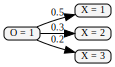

In [4]:
# Creata a blank probability tree.
pt = PTree()

# Add a root node and the children.
pt.root(
    'O = 1',
    [pt.child(0.5, 'X = 1'),
     pt.child(0.3, 'X = 2'),
     pt.child(0.2, 'X = 3')])

# Display it.
display(pt.show())

We'll typically call the root node $O$, standing for "**O**mega" ($\Omega$),
which is a common name for the sample space in the literature.

After creating a probability tree, we can ask it to return: 
-   the list of random variables and their values using the method `rvs()`; 
-   the probability distribution for a given random variable using 
`rv(varname)`; 
- the expected value of a *numerical* random variable with 
`expected(varname)`;
- and obtain a random sample from the tree with `sample()`.

In [5]:
rvs = pt.rvs()
print('Random variables:', rvs)

pdist = pt.rv('X')
print('P(X) =', pdist)

expect = pt.expect('X')
print('E(X) =', expect)

smp = pt.sample()
print('Sample =', smp)

Random variables: {'O': ['1'], 'X': ['1', '2', '3']}
P(X) = [(0.5, '1'), (0.3, '2'), (0.2, '3')]
E(X) = 1.7000000000000002
Sample = {'O': '1', 'X': '1'}


### Causal dependencies

In a probability tree, a causal dependency $X \rightarrow Y$ is expressed
through a node $X$ having a descendent node $Y$. For instance, consider the next
probability tree:

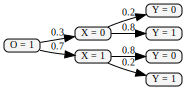

In [6]:
# Create a blank probability tree.
pt = PTree()

# Add a root node and the children.
pt.root('O = 1', [
    pt.child(0.3, 'X = 0', [
        pt.child(0.2, 'Y = 0'),
        pt.child(0.8, 'Y = 1'),
    ]),
    pt.child(0.7, 'X = 1', [
        pt.child(0.8, 'Y = 0'),
        pt.child(0.2, 'Y = 1'),
    ]),
])

# Display it.
display(pt.show())

Here $Y$ is a descendant of $X$ and therefore $X \rightarrow Y$. This means that
we can affect the value of $Y$ by choosing $X$ but not viceversa. The exact
semantics of this requires **interventions**, which we'll review later. Notice
how the value of $X$ changes the distribution over $Y$: - $P(Y=1|X=0) >
P(Y=0|X=0)$, - $P(Y=1|X=1) < P(Y=0|X=1)$.

If we want to express that neither $X \rightarrow Y$ nor $Y \rightarrow X$ are
the case, then we need to combine both random variables into the same nodes as
follows:

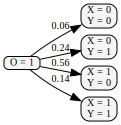

In [7]:
# Creata a blank probability tree.
pt = PTree()

# Add a root node and the children.
pt.root('O = 1', [
    pt.child(0.3 * 0.2, 'X = 0, Y = 0'),
    pt.child(0.3 * 0.8, 'X = 0, Y = 1'),
    pt.child(0.7 * 0.8, 'X = 1, Y = 0'),
    pt.child(0.7 * 0.2, 'X = 1, Y = 1')
])

# Display it.
display(pt.show())

### Another tree: drug testing

Let's build another example. Here we have a drug testing situation:

-   A patient has a probability of being ill ($D = 1$).
-   If the patient takes the drug ($T = 1$) when she is ill, she will likely
    feel better ($R = 1$), otherwise she will likely feel worse ($R = 0$).
-   However, if she takes the drug when she is not ill, the situation is
    inverted: the drug might make her feel worse ($R = 0$).

![Drug Testing CBN](http://www.adaptiveagents.org/_media/wiki/drug-testing.png)

This tree can also be represented as the above causal Bayesian graph. This is
always the case when the causal ordering of the random variables is the same, no
matter which realization path is taken in the tree.

Random variables: {'O': ['1'], 'D': ['0', '1'], 'T': ['0', '1'], 'R': ['0', '1']}


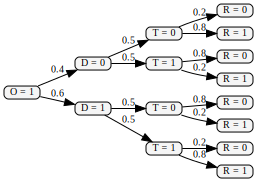

In [8]:
med = PTree()
med.root('O = 1', [
    med.child(0.4, 'D = 0', [
        med.child(0.5, 'T = 0',
                  [med.child(0.2, 'R = 0'),
                   med.child(0.8, 'R = 1')]),
        med.child(0.5, 'T = 1',
                  [med.child(0.8, 'R = 0'),
                   med.child(0.2, 'R = 1')])
    ]),
    med.child(0.6, 'D = 1', [
        med.child(0.5, 'T = 0',
                  [med.child(0.8, 'R = 0'),
                   med.child(0.2, 'R = 1')]),
        med.child(0.5, 'T = 1',
                  [med.child(0.2, 'R = 0'),
                   med.child(0.8, 'R = 1')])
    ])
])

print('Random variables:', med.rvs())
display(med.show())

### A tree that cannot be represented as a Bayesian graph: Weather-Barometer Worlds

We can also build a tree where the different realization paths have different
causal dependencies. For instance, imagine we have two possible worlds: - Our
world ($A = 0$) where the weather ($W$) influences the barometer reading
($B$); - An alien world ($A = 1$) where the barometer influences the weather.

Such a situation with multiple causal dependencies cannot be captured in a
single graphical model:

![Weather-Barometer Worlds](http://www.adaptiveagents.org/_media/wiki/weather-barometer-worlds.png)

However, we can represent it using a probability tree:

![Weather-Barometer Worlds Probability Tree](http://www.adaptiveagents.org/_media/wiki/wb_tree.png)

### Exercise 1

Now it's your turn to create a probability tree. Create the "weather-barometer
worlds" probability tree and name it `wb`.

#### Solution

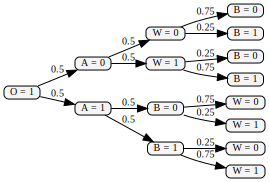

In [9]:
# Create blank tree.
wb = PTree()

# Set the root node and its sub-nodes.
wb.root('O = 1', [
    wb.child(0.5, 'A = 0', [
        wb.child(0.5, 'W = 0',
                 [wb.child(0.75, 'B = 0'),
                  wb.child(0.25, 'B = 1')]),
        wb.child(0.5, 'W = 1',
                 [wb.child(0.25, 'B = 0'),
                  wb.child(0.75, 'B = 1')])
    ]),
    wb.child(0.5, 'A = 1', [
        wb.child(0.5, 'B = 0',
                 [wb.child(0.75, 'W = 0'),
                  wb.child(0.25, 'W = 1')]),
        wb.child(0.5, 'B = 1',
                 [wb.child(0.25, 'W = 0'),
                  wb.child(0.75, 'W = 1')])
    ])
])

# Display it.
display(wb.show())

### Remember:

-   A node can contain more than one statement.
-   The tree doesn't have to be balanced.

See the next example.

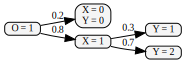

In [10]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.2, 'X = 0, Y = 0'),
    pt.child(0.8, 'X = 1', [pt.child(0.3, 'Y = 1'),
                            pt.child(0.7, 'Y = 2')])
])

display(pt.show())

### Displaying additional information

We can display additional information about probability trees: 
- **Unique identifiers**: Each node has an automatically assigned 
unique identifier. Use `show_id = True` to display it. 
- **Probability**: Each node has a probability of being realized. 
Use `show_prob = True` to display this information.

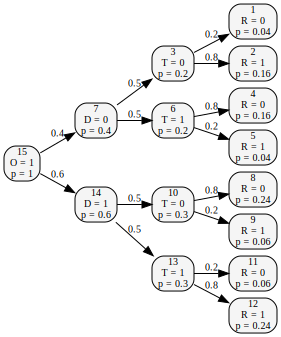

In [11]:
display(med.show(show_prob=True, show_id=True))

### Exercise 2

For the probability tree `wb`: 
- list all the random variables; 
- compute the probability distribution of the barometer ($B$); 
- display the probability tree with the unique ids and probabilities
of every node.

#### Solution

{'O': ['1'], 'A': ['0', '1'], 'W': ['0', '1'], 'B': ['0', '1']}
[(0.5, '0'), (0.5, '1')]


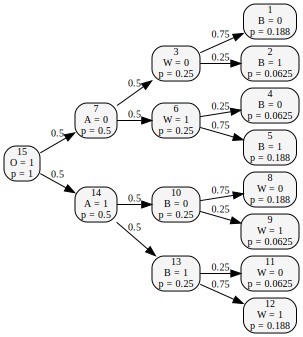

In [12]:
print(wb.rvs())
print(wb.rv('B'))
display(wb.show(show_id=True, show_prob=True))

## 2. Propositions and min-cuts

We've seen that a probability tree is a simple way of representing all the
possible realizations and their causal dependencies. We now investigate the
possible **events** in a probability tree.

An **event** is a collection of full realizations. We can **describe** events
using propositions about random variables (e.g. $W = 0$, $B = 1$) and the
logical connectives of negation, conjunction (AND), and disjunction (OR). The
connectives allow us to state composite events, such as $\neg(W = 1 \wedge B =
0)$. For instance, the event $B = 0$ is the set of all realizations, i.e. paths
from the root to a leaf, that **pass through a node** with the statement $B=0$.

We can **represent** events using cuts, and in particular, **min-cuts**. A
**min-cut** is a minimal representation of an event in terms of the nodes of a
probability tree. The min-cut of an event collects the smallest number of nodes
in the probability tree that resolves whether an event has occurred or not. In
other words, if a realization hits a node in the min-cut, then we know for sure
whether the event has occurred or not. (In measure theory, a similar notion to
min-cut would be the algebra that renders the event measurable.)

Our implementation of min-cuts furthermore distinguishes between the nodes that
render the event true from the nodes that render the event false.

Let's start by constructing a min-cut for a setting of a random variable in our
drug testing example. Verify that the min-cut is correct for the setting of the
random variable.

Type of a cut: <class '__main__.MinCut'>
Min-cut for "R = 1": {true: {2, 5, 9, 12}, false: {1, 4, 8, 11}}


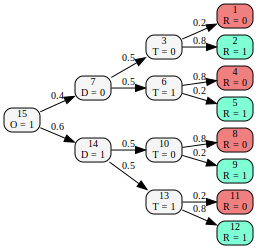

In [13]:
# Build a cut for the proposition 'R = 1'.
cut = med.prop('R=1')

# The result is of type MinCut:
print('Type of a cut:', type(cut))

# Print the min-cut. Note that the elements in the
# true and false sets refer to the ids of the prob tree.
print('Min-cut for "R = 1":', cut)

# Render the probability tree with a cut.
display(med.show(cut=cut, show_id=True))

Let's do a min-cut for not taking the treatment ($T = 0$)

Min-cut for "T = 0": {true: {3, 10}, false: {6, 13}}


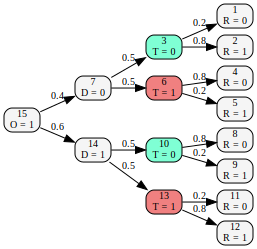

In [14]:
# Build a cut for the proposition 'T = 0'.
cut = med.prop('T=0')

# Print the min-cut. Note that the elements in the
# true and false sets refer to the ids of the prob tree.
print('Min-cut for "T = 0":', cut)

# Render the probability tree with a cut.
display(med.show(cut=cut, show_id=True))

We can build negative events too using the `~` unary operator. As an example,
let's negate the previous event. Compare the two cuts. Notice that a negation
simply inverts the nodes that are true and false.

Min-cut for "T = 0": {true: {3, 10}, false: {6, 13}}
Min-cut for "not T = 0": {true: {6, 13}, false: {3, 10}}


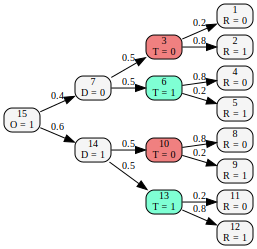

In [15]:
cut = ~med.prop('T = 0')
print('Min-cut for "T = 0":', med.prop('T = 0'))
print('Min-cut for "not T = 0":', ~med.prop('T = 0'))
display(med.show(cut=cut, show_id=True))

Now let's build more complex events using conjunctions (`&`) and disjunctions
(`|`). Make sure these min-cuts make sense to you. Notice that the conjunction
of two events pick out the earliest occurrence of false nodes and the last
occurence of true nodes, whereas the disjunction does the opposite.

Cut for "R = 1":


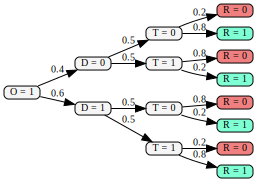

Cut for "T=1":


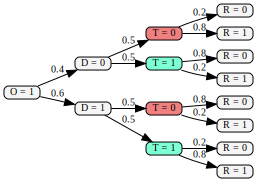

Cut for "T=1 and R=1":


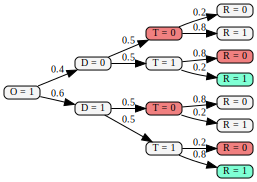

Cut for "T=1 or R=1":


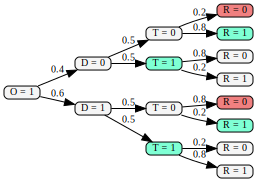

In [16]:
# Recovery
cut1 = med.prop('R=1')
print('Cut for "R = 1":')
display(med.show(cut=cut1))

# Taking the treatment
cut2 = med.prop('T=1')
print('Cut for "T=1":')
display(med.show(cut=cut2))

# Conjunction: taking the treatment and recovery
cut_and = cut1 & cut2
print('Cut for "T=1 and R=1":')
display(med.show(cut=cut_and))

# Disjunction: taking the treatment or recovery
cut_or = cut1 | cut2
print('Cut for "T=1 or R=1":')
display(med.show(cut=cut_or))

### The precedence relation

In addition to the Boolean operators, we can also use a causal connective which
cannot stated in logical terms: the **precedence relation** $\prec$. This
relation allows building min-cuts for events where one event $A$ precedes
another event $B$, written $A \prec B$, and thus requires the additional
information provided by the probability tree's structure.

Let's try one example. We want to build the min-cut where having the disease
($D=1$) precedes feeling better ($R=1$), and vice-versa.

Cut for D=1 < R=1:


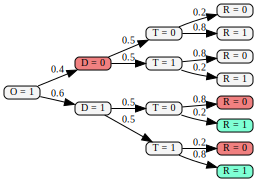

Cut for R=1 < D=1:


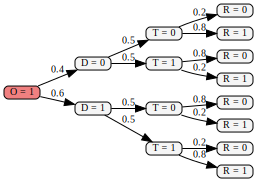

In [17]:
# Disease and recovery min-cuts.
cut1 = med.prop('D=1') < med.prop('R=1')
cut2 = med.prop('R=1') < med.prop('D=1')

# Display.
print('Cut for D=1 < R=1:')
display(med.show(cut=cut1))

print('Cut for R=1 < D=1:')
display(med.show(cut=cut2))

### Requirement: random variables must be measurable

If we try to build a min-cut using a variable that is not measurable, then an
exception is raised. For instance, the random variable $X$ below is not
measurable within the probability tree, because the realization starting at the
root and reaching the leaf $Y = 2$ never sets the value for $X$.

Attempting to build a min-cut for an event involving $X$ will throw an error.

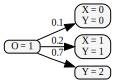

In [18]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.1, 'X = 0, Y = 0'),
    pt.child(0.2, 'X = 1, Y = 1'),
    pt.child(0.7, 'Y = 2')
])

display(pt.show())

### Special case: probabilistic truth versus logical truth

Let's have a look at one special case. Our definitions make a distinction
between **logical** and **probabilistic truth**. This is best seen in the
example below.

In this example, we have a probability tree with three outcomes: $X = 1, 2$, and
$3$. - $X = 1$ occurs with probability one. 
- Hence, probabilistically, the event $X=1$ is resolved at the level of the
root node. 
- However, it isn't resolved at the logical level, since $X = 2$ or $X = 3$ 
can happen logically, although with probability zero.

Distinguishing between logical truth and probabilistic truth is important for
stating counterfactuals. This will become clearer later.

While the root node "O=1" does resolve the event "X=1"
probabilistically, it does not resolve the event logically.


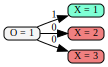

In [19]:
# First we add all the nodes.
pt = PTree()
pt.root('O = 1',
        [pt.child(1, 'X = 1'),
         pt.child(0, 'X = 2'),
         pt.child(0, 'X = 3')])

# Show the cut for 'X = 0'
cut = pt.prop('X = 1')
print('While the root node "O=1" does resolve the event "X=1"\n' +
      'probabilistically, it does not resolve the event logically.')
display(pt.show(cut=cut))

### Exercise 3

For the `wb` probability tree, build the min-cuts for the following events:
- the world is alien ($A = 1$); 
- the weather is sunny ($W = 1$); 
- the barometer goes down and the weather is sunny ($B = 0 \wedge W = 1$); 
- the negation of "barometer does not go down or weather is not sunny", 
$\neg(\neg(B = 0) \vee \neg(W = 1))$.

Display every min-cut. In particular, compare the last two. What do you observe?

#### Solution

Cut for "A=1":


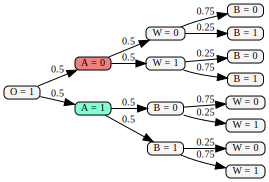

Cut for "W=1":


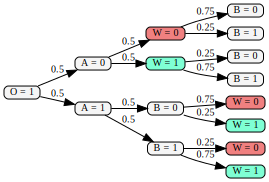

Cut for "B=0 and W=1":


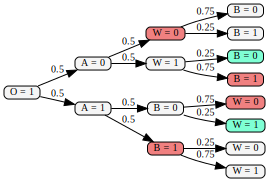

Cut for "not( not(B=0) or not(W=1) )":


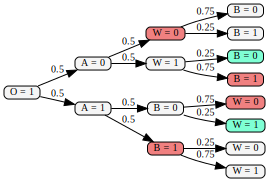

In [20]:
# Exercise.

# A = 1.
cut = wb.prop('A=1')
print('Cut for "A=1":')
display(wb.show(cut=cut))

# W = 1.
cut = wb.prop('W=1')
print('Cut for "W=1":')
display(wb.show(cut=cut))

# B = 0 and W = 1.
cut = wb.prop('B=0') & wb.prop('W=1')
print('Cut for "B=0 and W=1":')
display(wb.show(cut=cut))

# not( not(B = 0) or not(W = 1) ).
cut = ~(~wb.prop('B=0') | ~wb.prop('W=1'))
print('Cut for "not( not(B=0) or not(W=1) )":')
display(wb.show(cut=cut))

### Exercise 4

For the `wb` probability tree, determine the min-cut for whenever the weather
($W$) affects the value of the barometer ($B$). This min-cut should coincide
with the min-cut for the event ($A=0$).

Hint: enumerate all the 4 cases (values for $W$ and $B$) and combine them using
disjunctions.

#### Solution

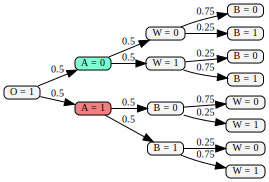

In [21]:
# Build the min-cut.
cut = (wb.prop('W=0') < wb.prop('B=0')) \
    | (wb.prop('W=0') < wb.prop('B=1')) \
    | (wb.prop('W=1') < wb.prop('B=0')) \
    | (wb.prop('W=1') < wb.prop('B=1'))

# Display.
display(wb.show(cut=cut))

## 3. Critical sets

Min-cuts correspond to the smallest set of nodes where it becomes clear whether
an event has occurred or not. Every min-cut has an associated **critical set**:
the set of nodes that **determines** whether an event won't occur. Given an
event, the associated **critical set** is defined as the set of parents of the
event's false set in the min-cut.

Together, a critical set and a min-cut form the set of **mechanisms** that
determine the occurrence of the event.

Let's have a look at a simple example. Here, the critical set is the singleton
containing the root node. Critical sets are computed using the function
`PTree.critical(cut)`, where `cut` is an event's min-cut. We can display the
critical set by providing the optional argument `crit` to the `PTree.show()`
function.

Min-cut for "X=1": {true: {1}, false: {2, 3}}
Critical set for "X=1": {4}


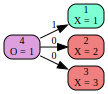

In [22]:
# First we add all the nodes.
pt = PTree()
pt.root('O = 1',
        [pt.child(1, 'X = 1'),
         pt.child(0, 'X = 2'),
         pt.child(0, 'X = 3')])

# Get the critical set for a min-cut.
cut = pt.prop('X = 1')
crit = pt.critical(cut)

# Show the critical set.
print('Min-cut for "X=1":', cut)
print('Critical set for "X=1":', crit)
display(pt.show(show_id=True, cut=cut, crit=crit))

Let's work out another example. Consider the following probability tree.

![Min-Cuts and Critical Sets](http://www.adaptiveagents.org/_media/wiki/mincut-critical.png)

Try to predict the min-cut and the critical set of the events $X=1$, $Y=1$, and
$Y=0$.

Original tree:


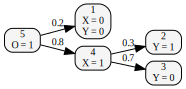

Min-cut and critical set for "X=1":


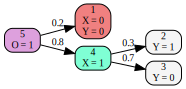

Min-cut and critical set for "Y=1":


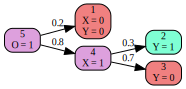

Min-cut and critical set for "Y=0":


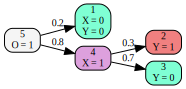

In [23]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.2, 'X = 0, Y = 0'),
    pt.child(0.8, 'X = 1', [pt.child(0.3, 'Y = 1'),
                            pt.child(0.7, 'Y = 0')])
])

# Original tree.
print('Original tree:')
display(pt.show(show_id=True))

# 'X=1'
cut = pt.prop('X=1')
crit = pt.critical(cut)
print('Min-cut and critical set for "X=1":')
display(pt.show(show_id=True, cut=cut, crit=crit))

# 'Y=1'
cut = pt.prop('Y=1')
crit = pt.critical(cut)
print('Min-cut and critical set for "Y=1":')
display(pt.show(show_id=True, cut=cut, crit=crit))

# 'Y=0'
cut = pt.prop('Y=0')
crit = pt.critical(cut)
print('Min-cut and critical set for "Y=0":')
display(pt.show(show_id=True, cut=cut, crit=crit))

### Exercise 5

For the `wb` tree, compute and display the mechanisms (i.e. the min-cut and the
critical set) for the following events: 
- the world is alien ($A = 1$); 
- the barometer goes down ($B = 0$); 
- the weather is sunny ($W = 1$); 
- the barometer goes down and weather is sunny ($B = 0 \wedge W = 1$).

#### Solution

Mechanism for "A=1":


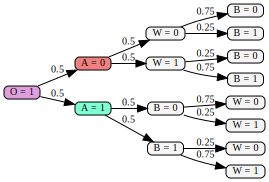

Mechanisms for "B=0":


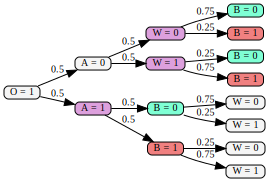

Mechanisms for "W=1":


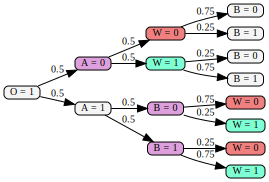

Mechanisms for "B=0 and W=1":


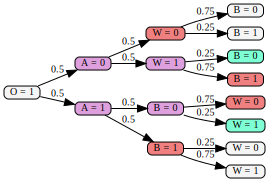

In [24]:
# Exercise.

# A = 1.
cut = wb.prop('A=1')
crit = wb.critical(cut)
print('Mechanism for "A=1":')
display(wb.show(cut=cut, crit=crit))

# B = 0.
cut = wb.prop('B=0')
crit = wb.critical(cut)
print('Mechanisms for "B=0":')
display(wb.show(cut=cut, crit=crit))

# W = 1.
cut = wb.prop('W=1')
crit = wb.critical(cut)
print('Mechanisms for "W=1":')
display(wb.show(cut=cut, crit=crit))

# B = 0 and W = 1.
cut = wb.prop('B=0') & wb.prop('W=1')
crit = wb.critical(cut)
print('Mechanisms for "B=0 and W=1":')
display(wb.show(cut=cut, crit=crit))

We'll return later to critical sets, as they are important for determining the
operations of conditioning and intervening on probability trees.

## 4. Evaluating probabilities

We can also evaluate probabilities of events. For instance, you may ask:

-   "$P(R=1)$: What is the probability of recovery?"
-   "$P(R=0)$: What is the probability of not recovering?"
-   "$P(D=1)$: What is the probability of having the disease?"
-   "$P(D=1 \wedge R=0)$: What is the probability of taking the drug and not
    recovering?"
-   "$P(D=1 \vee R=0)$: What is the probability of taking the drug or not
    recovering?"
-   "$P(D=1 \prec R=1)$: What is the probability of taking the drug preceding
    the recovery?"

To do so, we use the min-cut of the event.

Let's have a look at some of them. Compare to the graph of the probability tree.

P(R=1) = 0.5
P(R=0) = 0.5
P(D=1) = 0.6
P(D=1 and R=0) = 0.3
P(D=1 or R=0) = 0.8
P(D=1 precedes R=1) = 0.3


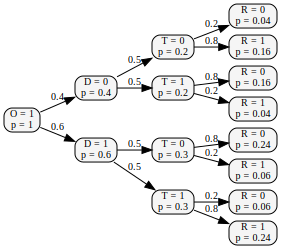

In [25]:
# Min-cuts for some events
cut1 = med.prop('R=1')
cut2 = med.prop('D=1')
cut1_neg = ~cut1
cut_and = cut2 & cut1_neg
cut_or = cut2 | cut1_neg
cut_prec = cut2 < cut1

print('P(R=1) =', med.prob(cut1))
print('P(R=0) =', med.prob(cut1_neg))
print('P(D=1) =', med.prob(cut2))
print('P(D=1 and R=0) =', med.prob(cut_and))
print('P(D=1 or R=0) =', med.prob(cut_or))
print('P(D=1 precedes R=1) =', med.prob(cut_prec))

display(med.show(show_prob=True))

### Exercise 6

For the `wb` tree, evaluate the probability of the following events: 
- the world is ours ($A = 0$) and the barometer goes down ($B = 0$); 
- it is not the case that the barometer goes down or the weather 
is sunny ($\neg(B = 0 \vee W = 1)$).

Print the probabilities and display the probability trees.

#### Solution

P(A=0 and B=0) = 0.25


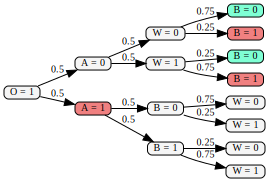

P(not(B=0 or W=1)) = 0.125


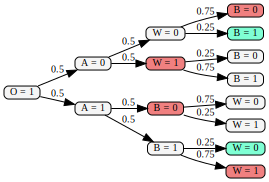

In [26]:
# Exercise.

# A = 0 and B = 0
cut = wb.prop('A=0') & wb.prop('B=0')
print('P(A=0 and B=0) =', wb.prob(cut))
display(wb.show(cut=cut))

# not(B = 0 or W = 1)
cut = ~(wb.prop('B=0') | wb.prop('W=1'))
print('P(not(B=0 or W=1)) =', wb.prob(cut))
display(wb.show(cut=cut))

## 5. Conditioning

We have learned how to represent events using min-cuts. Now we can use min-cuts
to **condition** probability trees **on events**. Conditioning allows asking
questions after making **observations**, such as:

-   "$P(R=1|T=1)$: What is the probability of recovery given that a patient has
    taken the treatment?"
-   "$P(D=1|R=1)$: What is the probability of having had the disease given that
    a patient has recovered/felt better?"

### How to compute conditions

Conditioning takes a probability tree and produces a new probability tree with
modified transition probabilities. These are obtained by removing all the total
realizations that are **incompatible with the condition**, and then
renormalizing, as illustrated below.

<img src="http://www.adaptiveagents.org/_media/wiki/see.png" alt="Seeing" width="700"/>

In the example, we compute the result of seeing $Y= 1$. 
Conditioning on an event proceeds in two steps: 
- first, we remove the probability mass of the realizations
passing through the false set of the event’s min-cut 
(hihglighted in dark, bottom row); 
- then we renormalize the probabilities. 

We can do this recursively by aggregating the original probabilities 
of the true set. The top row shows the result of conditioning a
probability tree on the event $Y= 1$, which also highlights the modified
transition probabilities in red. The bottom row shows the same 
operation in a probability mass diagram, which is a representation of a
probability tree that emphasizes the probabilities.

Let's have a look at the drug testing example. We will condition on $R=1$.
Observe how the probabilities change.

Before conditioning: P(R=1) = 0.5
After  conditioning: P(R=1 | R=1) = 1.0

Original tree:


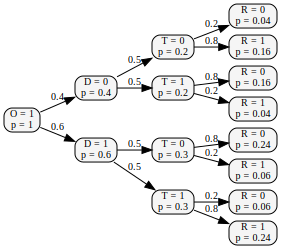

Tree after conditioning on "R=1":


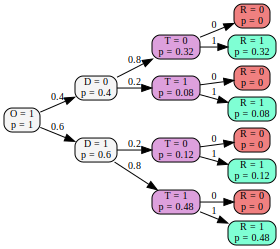

In [27]:
# Now we condition.
cut = med.prop('R=1')
med_see = med.see(cut)

# Critical set.
crit = med.critical(cut)

# Compare probabilities of events.
print('Before conditioning: P(R=1) =', med.prob(cut))
print('After  conditioning: P(R=1 | R=1) =', med_see.prob(cut))

# Display both trees for comparison.
print('\nOriginal tree:')
display(med.show(show_prob=True))

print('Tree after conditioning on "R=1":')
display(med_see.show(cut=cut, crit=crit, show_prob=True))

We can condition on composite events too and evaluate the probability of events.

Assume you observe that the drug was taken and a recovery is observed. Then, it
is very likely that the patient had the disease.

P(D = 1) = 0.6
P(D = 1 | R = 1) = 0.6
P(D = 1 | T = 1, R = 1) = 0.857142857142857

Probability tree after conditioning on "T=1 and R=1":


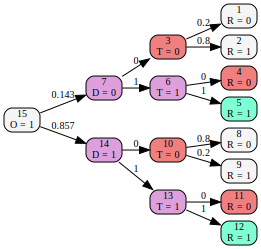

In [28]:
# Min-cuts.
cut_r = med.prop('R=1')
cut_tr = med.prop('T=1') & med.prop('R=1')
cut_disease = med.prop('D=1')

# Critical set.
crit = med.critical(cut_tr)

# Condition.
med_see_r = med.see(cut_r)
med_see_tr = med.see(cut_tr)

# Now we evaluate the posterior probability of having a disease.
print('P(D = 1) =', med.prob(cut_disease))
print('P(D = 1 | R = 1) =', med_see_r.prob(cut_disease))
print('P(D = 1 | T = 1, R = 1) =', med_see_tr.prob(cut_disease))

# Display prob tree.
print('\nProbability tree after conditioning on "T=1 and R=1":')
display(med_see_tr.show(cut=cut_tr, show_id=True, crit=crit))

### Special case: conditioning on trivial events

Let's have a look at a special case: conditioning on **trivial events**, namely
the **sure event** and the **impossible event**.

Observe that conditioning on trivial events does not change the probability
tree.

Original tree:


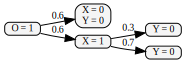

Conditioning on "Y = 0":


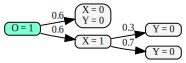

Conditioning on "not Y = 0":


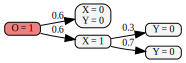

In [29]:
# Create a simple tree.
pt = PTree()
pt.root('O = 1', [
    pt.child(0.6, 'X = 0, Y = 0'),
    pt.child(0.6, 'X = 1', [pt.child(0.3, 'Y = 0'),
                            pt.child(0.7, 'Y = 0')]),
])

# Show tree.
print('Original tree:')
display(pt.show())

# Condition on Y = 0.
cut = pt.prop('Y=0')
pt_see_sure = pt.see(cut)
print('Conditioning on "Y = 0":')
display(pt_see_sure.show(cut=cut))

# Condiiton on not Y = 0.
neg_cut = ~cut
pt_see_impossible = pt.see(neg_cut)
print('Conditioning on "not Y = 0":')
display(pt_see_impossible.show(cut=neg_cut))

### Special case: conditioning on an event with probability zero

Let's return to our simple example with tree outcomes. Assume we're conditioning
on an event with **probability zero**, which can happen **logically but not
probabilistically**. Using the measure-theoretic definition of conditional
probabilities, we are required to pick a so-called **version** of the
conditional distribution. There are infinite choices.

Here, we have settled on the following. If we condition on an event with
probability zero, then we assign uniform probability over all the possible
transitions. This is just one arbitrary way of solving this problem.

See the example below.

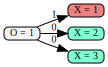

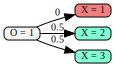

In [30]:
# Create a simple tree.
pt = PTree()
pt.root(
    'O = 1',
    [pt.child(1.0, 'X = 1'),
     pt.child(0.0, 'X = 2'),
     pt.child(0.0, 'X = 3')])

# Let's pick the negative event for our minimal prob tree.
cut = ~pt.prop('X = 1')
display(pt.show(cut=cut))

pt_see = pt.see(cut)
display(pt_see.show(cut=cut))

### Exercise 7

For the `wb` tree, print the probability distribution of 
- the weather $W$ 
- and the barometer $B$.

Do this for the following probability trees: 
- the original tree 
- the probability tree conditioned on it being an alien world ($\theta = 1$) 
- the probability tree conditioned on the weather being sunny ($W = 1$).

What do you observe? Does observing (conditioning) give you any additional
information? If no, why? If yes, why is that?

#### Solution

In [31]:
# Exercise

# No condition.
print('P(W) =', wb.rv('W'))
print('P(B) =', wb.rv('B'))

# Condition on "A = 1"
cut = wb.prop('A=1')
print('P(W | A=1) =', wb.see(cut).rv('W'))
print('P(B | A=1) =', wb.see(cut).rv('B'))

# Condition on "W = 1"
cut = wb.prop('W=1')
print('P(W | W=1) =', wb.see(cut).rv('W'))
print('P(B | W=1) =', wb.see(cut).rv('B'))

P(W) = [(0.5, '0'), (0.5, '1')]
P(B) = [(0.5, '0'), (0.5, '1')]
P(W | A=1) = [(0.5, '0'), (0.5, '1')]
P(B | A=1) = [(0.5, '0'), (0.5, '1')]
P(W | W=1) = [(0.0, '0'), (1.0, '1')]
P(B | W=1) = [(0.25, '0'), (0.75, '1')]


## 6. Interventions

Interventions are at the heart of causal reasoning.

We have seen how to filter probability trees using observational data through
the use of conditioning. Now we investigate how a probability tree transforms
when it is intervened. An **intervention** is a change to the random process
itself to make something happen, as opposed to a filtration. We can ask
questions like:

-   "$P(R=1|T \leftarrow 1)$: What is the probability of recovery given that **I
    take the drug**?"
-   "$P(D=1|T \leftarrow 1 \wedge R=1)$: What is the probability of having the
    disease given **that I take the drug** and that I observe a recovery?"

Here, the notation $T \leftarrow 1$ is a shorthand for the more common notation
$\mathrm{do}(T = 1)$.

### How to compute interventions

Interventions differ from conditioning in the following: 
- they change the transition probabilities **minimally**, 
so as to make a desired event happen; 
- they **do not filter** the total realizations of the probability tree; 
- they are **easier to execute** than conditions, because they only 
change the transition probabilities that leave the critical set, 
and they do not require the backward induction of probabilities. 

See the illustration below.

<img src="http://www.adaptiveagents.org/_media/wiki/do.png" alt="Doing" width="700"/>

Example intervention on $Y \leftarrow 1$. An intervention proceeds in two steps:
- first, it selects the partial realizations starting in a critical node 
and ending in a leaf that traverse the false set of the event’s min-cut; 
- then it removes their probability mass, renormalizing the probabilities
from the transitions leaving the critical set. 

The top row shows the result of intervening a probability tree
on $Y \leftarrow 1$. The bottom row show the same procedure on 
the corresponding probability mass diagram.

Let's start with a simple comparison to illustrate the difference.

Original:


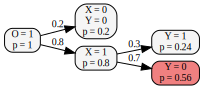

Condition on "Y=1":


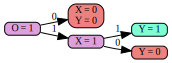

Intervention on "Y<-1":


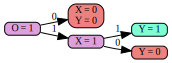

Condition on "Y = 0":


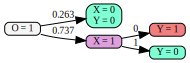

Intervention on "Y <- 0":


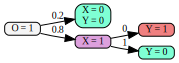

In [32]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.2, 'X = 0, Y = 0'),
    pt.child(0.8, 'X = 1', [pt.child(0.3, 'Y = 1'),
                            pt.child(0.7, 'Y = 0')])
])

print('Original:')
display(pt.show(show_prob=True, cut=cut, crit=crit))

# 'Y=1'
cut = pt.prop('Y = 1')
crit = pt.critical(cut)
pt_see = pt.see(cut)
pt_do = pt.do(cut)
print('Condition on "Y=1":')
display(pt_see.show(cut=cut, crit=crit))
print('Intervention on "Y<-1":')
display(pt_do.show(cut=cut, crit=crit))

# 'Y=0'
cut = pt.prop('Y = 0')
crit = pt.critical(cut)
pt_see = pt.see(cut)
pt_do = pt.do(cut)
print('Condition on "Y = 0":')
display(pt_see.show(cut=cut, crit=crit))
print('Intervention on "Y <- 0":')
display(pt_do.show(cut=cut, crit=crit))

Notice that the mechanisms for $Y=0$ and $Y=1$ are different. In general, a
single random variable can have **multiple mechanism** for setting their
individual values.

Let's return to our drug testing example. We investigate the effect of taking
the treatment, that is, by intervening on $T \leftarrow 1$. How do the
probabilities of: 
- having the disease ($D = 1$); 
- taking the treatment ($T = 1$); 
- and recovering ($R = 1$)

change after taking the treatment ($T \leftarrow 1$)?

Original tree:
P(D = 1) = 0.6
P(T = 1) = 0.5
P(R = 1) = 0.5


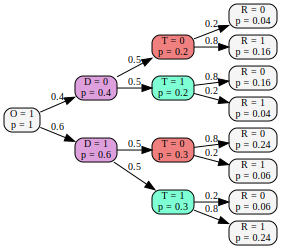

Tree after intervening on "T <- 1":
P(D = 1 | T <- 1) = 0.6
P(T = 1 | T <- 1) = 1.0
P(R = 1 | T <- 1) = 0.56


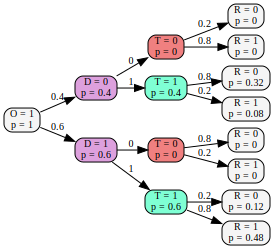

In [33]:
# Min-Cuts.
cut_dis = med.prop('D = 1')
cut_arg = med.prop('R = 1')
cut_do = med.prop('T = 1')

# Critical set.
crit_do = med.critical(cut_do)

# Perform intervention.
med_do = med.do(cut_do)

# Display original tree.
print('Original tree:')
print('P(D = 1) =', med.prob(cut_dis))
print('P(T = 1) =', med.prob(cut_do))
print('P(R = 1) =', med.prob(cut_arg))
display(med.show(cut=cut_do, show_prob=True, crit=crit_do))

# Display tree after invervention.
print('Tree after intervening on "T <- 1":')
print('P(D = 1 | T <- 1) =', med_do.prob(cut_dis))
print('P(T = 1 | T <- 1) =', med_do.prob(cut_do))
print('P(R = 1 | T <- 1) =', med_do.prob(cut_arg))
display(med_do.show(cut=cut_do, show_prob=True, crit=crit_do))

In other words, for the example above, taking the treatment increases the
chances of recovery. This is due to the base rates (i.e. the probability of
having a disease). The base rates are not affected by the decision of taking the
treatment.

### Special case: intervening on an event with probability zero

Assume we're intervening on an event with **probability zero**. Recall that this
is possible **logically**, but **not probabilistically**. How do we set the
transition probabilities leaving the critical set? Here again we settle on
assigning uniform probabilities over all the transitions affected by the
intervention.

See the example below.

Before the intervention:


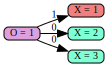

After the invention on "not X <- 1":


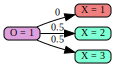

In [34]:
# Create a simple tree.
pt = PTree()
pt.root(
    'O = 1',
    [pt.child(1.0, 'X = 1'),
     pt.child(0.0, 'X = 2'),
     pt.child(0.0, 'X = 3')])

# Let's pick the negative event for our minimal prob tree.
cut = ~pt.prop('X = 1')
crit = pt.critical(cut)

# Intervene.
pt_do = pt.do(cut)

# Show results.
print('Before the intervention:')
display(pt.show(cut=cut, crit=crit))
print('After the invention on "not X <- 1":')
display(pt_do.show(cut=cut, crit=crit))

### Exercise 8

For the `wb` tree, print the probability distribution of 
- the weather $W$ 
- and the barometer $B$.

Do this for the following probability trees: 
- the original tree 
- the probability tree resulting from enforcing it to being 
an alien world ($A \leftarrow 1$) 
- the probability tree resulting from setting the weather to
being sunny ($W \leftarrow 1$).

What do you observe? Compare these results with your previous exercise, where
you conditioned on the same events. Why are the probabilities different when you
condition and when you intervene? How is this related to the different causal
dependencies in both worlds?

#### Solution

In [35]:
# Exercise

# No intervention.
print('P(W) =', wb.rv('W'))
print('P(B) =', wb.rv('B'))

# Intervention on "A <- 1"
cut = wb.prop('A=1')
print('P(W|A <- 1) =', wb.do(cut).rv('W'))
print('P(B|A <- 1) =', wb.do(cut).rv('B'))

# Condition on "W <- 1"
cut = wb.prop('W=1')
print('P(W|W <- 1) =', wb.do(cut).rv('W'))
print('P(B|W <- 1) =', wb.do(cut).rv('B'))

P(W) = [(0.5, '0'), (0.5, '1')]
P(B) = [(0.5, '0'), (0.5, '1')]
P(W|A <- 1) = [(0.5, '0'), (0.5, '1')]
P(B|A <- 1) = [(0.5, '0'), (0.5, '1')]
P(W|W <- 1) = [(0.0, '0'), (1.0, '1')]
P(B|W <- 1) = [(0.375, '0'), (0.625, '1')]


### Exercise 9

Next, evaluate the following probabilities:

-   What is the probability of being in our world ($A=0$), given that you
    observe a sunny weather ($W=1$) and the barometer going up ($B=1$)?
-   What is the probability of being in our world ($A=0$), given that you first
    observe a sunny weather ($W=1$) and then **you force** the barometer to go
    up ($B\leftarrow 1$)?
-   What is the probability of being in our world ($A=0$), given that you first
    **force** the barometer to go up ($B\leftarrow 1$) and then observe a sunny
    weather ($W=1$)?

Answer the following questions:

-   Does conditioning give different results from intervening? If so, why?
-   When you mix conditions and interventions, does the order matter? If so,
    why?

#### Solution

P(A = 0 | W = 1 and B = 1) = 0.5
P(A = 0 | W = 1 then B <- 1) = 0.5
P(A = 0 | B <- 1 then W = 1) = 0.4


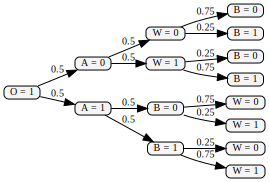

In [36]:
# Exercise
cutw = wb.prop('W=1')
cutb = wb.prop('B=1')
cuttheta = wb.prop('A=0')

# Question 1
print('P(A = 0 | W = 1 and B = 1) =', wb.see(cutw).see(cutb).prob(cuttheta))

# Question 2
print('P(A = 0 | W = 1 then B <- 1) =', wb.see(cutw).do(cutb).prob(cuttheta))

# Question 3
print('P(A = 0 | B <- 1 then W = 1) =', wb.do(cutb).see(cutw).prob(cuttheta))

display(wb.show())

## 7. Counterfactuals

Finally, we have counterfactuals. Counterfactuals are questions about how the
experiment could have gone if something about it were different. For instance:

-   "What is the probability of having the disease **had I not recovered**,
    given that I have recovered?"
-   "Given that I have taken the treatment and recovered, what is the
    probability of recovery **had I not taken the treatment**?"

These are tricky questions because they mix two moods:

-   **indicative statements** - things that have actually happened;
-   **subjunctive statements** - things that could have happened 
in an alternate reality/possible world.

Because of this, counterfactuals spawn a new scope of random variables:

<img src="http://www.adaptiveagents.org/_media/wiki/counterfactual.png" alt="Counterfactual" width="400"/>

These two questions above are spelled as follows:

-   $P(D^\ast=1|R=1)$, where $D^\ast=D_{R \leftarrow 0}$
-   $P(R^\ast=1|T\leftarrow 1; R=1)$, where $R^\ast=R_{T\leftarrow 0}$

Here the random variables with an asterisk $D^\ast, R^\ast$ are copies of the
original random variables $D, R$ that ocurr in an alternate reality. The
notation $D_{T \leftarrow 0}$ means that the random variable $D$ is in the new
scope spawned by the intervention on $T\leftarrow 0$.

### Computing a counterfactual

The next figure shows how to obtain a counterfactual:

<img src="http://www.adaptiveagents.org/_media/wiki/cf.png" alt="Computing a counterfactual" width="700"/>

The example shows a counterfactual probability tree generated by imposing $Y
\leftarrow 1$, given the factual premise $Z = 1$. Starting from a **reference
probability tree**, we first derive two additional trees: a **factual premise**,
capturing the current state of affairs; and a **counterfactual premise**,
represented as an intervention on the reference tree.

To form the counterfactual we proceed as follows:
-   We slice both derived trees along the critical set
of the counterfactual premise. 
-   Then, we compose the counterfactual tree by
taking the transition probabilities **upstream of the slice**
from the factual premise, and those **downstream of the slice** 
from the counterfactual premise. 

The events downstream then span a new scope containing copies 
of the original random variables (marked with "∗"), ready to 
adopt new values. 

In particular note that $Z^\ast = 0$ can happen in our alternate 
reality, even though we know that $Z = 1$.

Let's have a look at a minimal example.

Original:


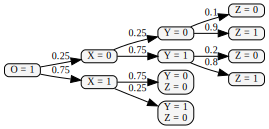

Condition on "Y = 0":


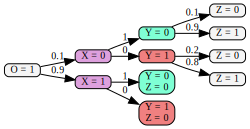

Intervention on "Y <- 1":


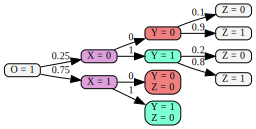

Counterfactual with premise "Y = 0" and subjunctive "Y = 1":


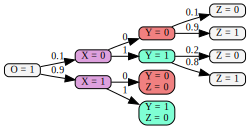

In [37]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.25, 'X = 0', [
        pt.child(0.25, 'Y = 0',
                 [pt.child(0.1, 'Z = 0'),
                  pt.child(0.9, 'Z = 1')]),
        pt.child(0.75, 'Y = 1',
                 [pt.child(0.2, 'Z = 0'),
                  pt.child(0.8, 'Z = 1')]),
    ]),
    pt.child(0.75, 'X = 1',
             [pt.child(0.75, 'Y = 0, Z = 0'),
              pt.child(0.25, 'Y = 1, Z = 0')])
])

print('Original:')
display(pt.show())

# Condition on 'Y=0', do 'Y=1'
cut_see = pt.prop('Y=0')
cut_do = pt.prop('Y=1')

# Critical set.
crit = pt.critical(cut_do)

# Evaluate conditional, intervention, and counterfactual.
pt_see = pt.see(cut_see)
pt_do = pt.do(cut_do)
pt_cf = pt.cf(pt_see, cut_do)

# Display results.
print('Condition on "Y = 0":')
display(pt_see.show(cut=cut_see, crit=crit))
print('Intervention on "Y <- 1":')
display(pt_do.show(cut=cut_do, crit=crit))
print('Counterfactual with premise "Y = 0" and subjunctive "Y = 1":')
display(pt_cf.show(cut=cut_do, crit=crit))

Now we return to our drug testing example. Let's ask the two questions we asked
before. We start with the question: "What is the probability of having the
disease **had I not recovered**, given that I have recovered?", that is
$$P(D^\ast=1|R=1), \qquad D^\ast=D_{R \leftarrow 0}.$$

Baseline:
P(D = 1) = 0.6


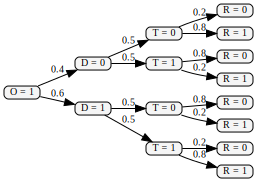

Premise:
P(D = 1 | R = 1) = 0.6


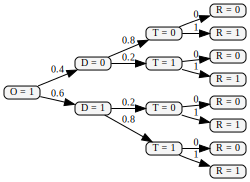

Counterfactual:
P(D* = 1 | R = 1) = 0.6 , D* = D[R <- 0]


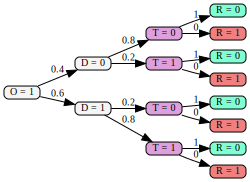

In [38]:
# Cuts.
cut_disease = med.prop('D = 1')
cut_recovery = med.prop('R = 1')
cut_not_recovery = ~cut_recovery

# Critical.
crit = med.critical(cut_not_recovery)

# Compute counterfactual:
# - compute factual premise,
# - use factual premise and subjunctive premise to compute counterfactual.
med_factual_prem = med.see(cut_recovery)
med_cf = med.cf(med_factual_prem, cut_not_recovery)

print('Baseline:')
print('P(D = 1) =', med.prob(cut_disease))
display(med.show())
print('Premise:')
print('P(D = 1 | R = 1) =', med_factual_prem.prob(cut_disease))
display(med_factual_prem.show())
print('Counterfactual:')
print('P(D* = 1 | R = 1) =', med_cf.prob(cut_disease), ', D* = D[R <- 0]')
display(med_cf.show(crit=crit, cut=cut_not_recovery))

As we can see, the probability of the disease in the indicative and the
counterfactual aren't different. This is because the recovery $R$ is independent
of the disease $D$, and because the disease is upstream of the critical set.

Let's have a look at the second question: $$P(R^\ast=1|T\leftarrow 1;
R=1), \qquad R^\ast=R_{T\leftarrow 0}$$

Baseline:
P(R = 1) = 0.5


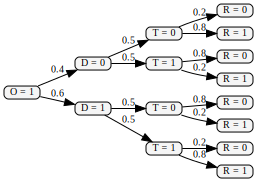

Premise:
P(R = 1 | T <- 1 and R = 1) = 0.9999999999999999


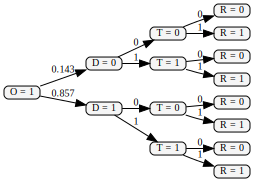

Counterfactual:
P(R* = 1 | T <- 1 and R = 1) = 0.2857142857142857 , R* = R[T <- 0]


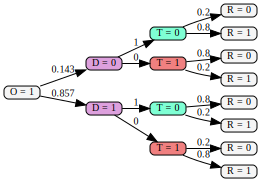

In [39]:
# Cuts.
cut_treatment = med.prop('T = 1')
cut_not_treatment = ~cut_treatment
cut_recovery = med.prop('R = 1')

# Critical.
crit = med.critical(cut_not_treatment)

# Compute counterfactual:
# - compute factual premise,
# - use factual premise and counterfactual premise to compute counterfactual.
med_factual_prem = med.do(cut_treatment).see(cut_recovery)
med_cf = med.cf(med_factual_prem, cut_not_treatment)

# Display results.
print('Baseline:')
print('P(R = 1) =', med.prob(cut_recovery))
display(med.show())

print('Premise:')
print('P(R = 1 | T <- 1 and R = 1) =', med_factual_prem.prob(cut_recovery))
display(med_factual_prem.show())

print('Counterfactual:')
print('P(R* = 1 | T <- 1 and R = 1) =', med_cf.prob(cut_recovery),
      ', R* = R[T <- 0]')
display(med_cf.show(cut=cut_not_treatment, crit=crit))

Hence, if I had not taken the treatment, then the probability of recovery would
have been lower. Why is that? 
-   In our premise, I have taken the treatment and
then observed a recovery. 
-   This implies that, most likely, I had the disease,
since taking the treatment when I don't have the disease is risky and can lead
to illness. 
-   Thus, knowing that I probably have the disease, I know that, had I
not taken the treatment, I would most likely not have recovered.

### Exercise 10

Consider the drug testing probability tree `med`.

-   Assume you take the drug ($T \leftarrow 1$) and you feel bad afterwards
    ($R = 0$).
-   Given this information, what is the probability of recovery ($R = 1$) had
    you not taken the drug ($T = 0$)?

Compute the **regret**, i.e. the difference: $$ \mathbb{E}[ R^\ast | T
\leftarrow 1; R = 0 ] - \mathbb{E}[ R | T \leftarrow 1; R = 0 ], $$ where
$R^\ast = R_{T \leftarrow 0}$.

#### Solution

P(R* = 1 | T <- 1, R = 0) = 0.6363636363636365
Regret =  0.6363636363636365


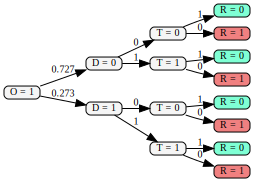

In [40]:
# Exercise

med_prem = med.do(med.prop('T=1')).see(med.prop('R=0'))
med_cf = med.cf(med_prem, med.prop('T=0'))

print('P(R* = 1 | T <- 1, R = 0) =', med_cf.prob(med.prop('R=1')))

regret = med_cf.expect('R') - med_prem.expect('R')
print('Regret = ', regret)

display(med_prem.show(cut=med.prop('R=0')))

### Exercise 11

Take the probability tree `wb`. Evaluate the following counterfactuals:

1.  Assume that you set the world to ours ($A \leftarrow 0$) and the weather to
    sunny ($W \leftarrow 1$). What is the probability distribution of observing
    a high barometer value ($B = 1$) had you set the weather to rainy ($W
    \leftarrow 0$)? Does the fact that you set the world and the weather affect
    the value of the counterfactual?

2.  Assume that you set the barometer to a high value ($B \leftarrow 1$), and
    you observe that the weather is sunny ($W=1$). What is the probability of
    observing a sunny weather ($W=1$) had you set the barometer to a low value
    ($B=0$)?

These are highly non-trivial questions. What do you observe? Do the results make
sense to you?

#### Solution

P(B*| A <- 0, W <- 1) = [(0.75, '0'), (0.25, '1')]  where B* = B[W <- 0]


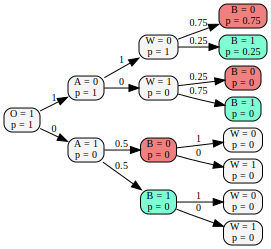

P(W* | B <- 1 then W <- 1) = [(0.44999999999999996, '0'), (0.55, '1')]  where W* = W[B <- 0]


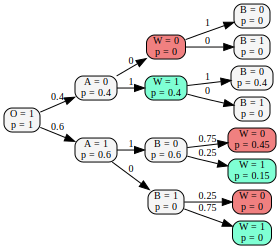

In [41]:
# Question 1.
wb_prem = wb.do(wb.prop('A=0')).do(wb.prop('W=1'))
wb_cf = wb.cf(wb_prem, wb.prop('W=0'))
print('P(B*| A <- 0, W <- 1) =', wb_cf.rv('B'), ' where B* = B[W <- 0]')
display(wb_cf.show(show_prob=True, cut=wb.prop('B=1')))

# Question 2.
wb_prem = wb.do(wb.prop('B=1')).see(wb.prop('W=1'))
wb_cf = wb.cf(wb_prem, wb.prop('B=0'))
print('P(W* | B <- 1 then W <- 1) =', wb_cf.rv('W'), ' where W* = W[B <- 0]')
display(wb_cf.show(show_prob=True, cut=wb.prop('W=1')))

# Part II: Examples

## Construction of probability trees using factory functions

Building probability trees can be difficult, especially when we have to manually
specify all its nodes. 

To simplify this, we could design a function `factory(bvar)` which: 
-   receives a dictionary `bvar` of bound random variables, such as 
`{ 'X': '1', 'Y': '0' }` 
-   and returns a list of transitions and their statements, such as 
`[(0.3, 'Z = 0'), (0.2, 'Z = 1'), (0.5, 'Z = 2')].` If all relevant
events have been defined already, return `None`.

Such a function contains all the necessary information for building a
probability tree. We call this a **probability tree factory**. We can pass a
description function to the method `PTree.fromFunc()` to build a probability
tree.

The advantage of using this method is that we can exploit symmetries (e.g.
conditional independencies) to code a much more compact description of the
probability tree. Essentially, it is like specifying a probabilistic program.

Let's experiment with this.

## Burglar, Earthquake, Alarm

Let's start with a classical example: a burglar alarm. The alarm gets 
triggered by a burglar breaking into our home. However, the alarm can 
also be set off by an earthquake. 

Let's define the factory function.

In [42]:
def alarm(bvar):
  # Define the burglar and earthquake events.
  if 'Burglar' not in bvar:
    pb = 0.1   # Probability of burglar
    pe = 0.001 # Probability of earthquake
    return [((1 - pb) * (1 - pe), 'Burglar=0, Earthquake=0'),
            ((1 - pb) * pe, 'Burglar=0, Earthquake=1'),
            (pb * (1 - pe), 'Burglar=1, Earthquake=0'),
            (pb * pe, 'Burglar=1, Earthquake=1')]

  # Define the alarm event.
  if 'Alarm' not in bvar:
    if bvar['Burglar'] == '0' and bvar['Earthquake'] == '0':
      return [(0.999, 'Alarm=0'), (0.001, 'Alarm=1')]
    if bvar['Burglar'] == '0' and bvar['Earthquake'] == '1':
      return [(0.01, 'Alarm=0'), (0.99, 'Alarm=1')]
    if bvar['Burglar'] == '1' and bvar['Earthquake'] == '0':
      return [(0.1, 'Alarm=0'), (0.9, 'Alarm=1')]
    else:
      return [(0.001, 'Alarm=0'), (0.999, 'Alarm=1')]

  # All the events defined.
  return None

Now, let's create the probability tree.

Random variables: {'Root': ['1'], 'Burglar': ['0', '1'], 'Earthquake': ['0', '1'], 'Alarm': ['0', '1']}

P(Alarm) = [(0.9082, '0'), (0.0918, '1')]

Original probability tree:


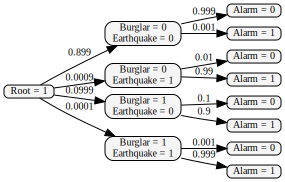


Some samples from the probability tree:
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '0'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '0'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '0'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '0'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '0'}


In [43]:
# Create the probability tree.
al = PTree.fromFunc(alarm, 'Root = 1')

# Print all the random variables.
print('Random variables:', al.rvs())
print('\nP(Alarm) =', al.rv('Alarm'))

print('\nOriginal probability tree:')
display(al.show())

print('\nSome samples from the probability tree:')
for k in range(5):
  print(al.sample())

Assume now you hear the alarm. Which explanation is more likely:
did the earthquake or the burglar trigger the alarm?

P(Earthquake = 1 | Alarm = 1) = 0.010794117647058824
P(Burglar = 1 | Alarm = 1) = 0.9804999999999999

Conditional probability tree:


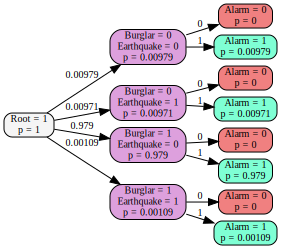


Some samples from the conditional probability tree:
{'Root': '1', 'Burglar': '1', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '1', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '1', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '1', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '1', 'Earthquake': '0', 'Alarm': '1'}


In [44]:
# Condition on the alarm going off.
cut = al.prop('Alarm=1')
crit = al.critical(cut)
al_see = al.see(cut)

# Compute probability distributions for earthquake and burglar.
print('P(Earthquake = 1 | Alarm = 1) =', al_see.prob(al.prop('Earthquake=1')))
print('P(Burglar = 1 | Alarm = 1) =', al_see.prob(al.prop('Burglar=1')))

# Display the conditional probability tree.

print('\nConditional probability tree:')
display(al_see.show(show_prob=True, cut=cut, crit=crit))

print('\nSome samples from the conditional probability tree:')
for k in range(5):
  print(al_see.sample())

As we can see, it is far more likely that the burglar set off the alarm.

If we now tamper with the alarm, setting it off, then what is the probability
that there was a burglar or an earthquake?

P(Earthquake = 1 | Alarm <- 1) = 0.001
P(Burglar = 1 | Alarm <- 1) = 0.1

Intervened probability tree:


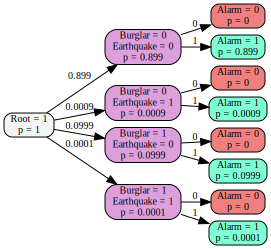


Some samples from the intervened probability tree:
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '1'}
{'Root': '1', 'Burglar': '0', 'Earthquake': '0', 'Alarm': '1'}


In [45]:
# Intervene on the alarm going off.
cut = al.prop('Alarm=1')
crit = al.critical(cut)
al_do = al.do(cut)

# Compute probability distributions for earthquake and burglar.
print('P(Earthquake = 1 | Alarm <- 1) =', al_do.prob(al.prop('Earthquake=1')))
print('P(Burglar = 1 | Alarm <- 1) =', al_do.prob(al.prop('Burglar=1')))

# Display the intervened probability tree.

print('\nIntervened probability tree:')
display(al_do.show(show_prob=True, cut=cut, crit=crit))

print('\nSome samples from the intervened probability tree:')
for k in range(5):
  print(al_do.sample())

Now we observe that the probabilities of the burglar and earthquake
events are exactly as the base rates - we have severed the
causal dependencies connecting those events with the alarm.

## Coin toss prediction

Let's build another probability tree. This is a discrete approximation to a
process having a continuous random variable: a **Beta-Bernoulli process**. 
This problem was first studied by Rev. Thomas Bayes ("An Essay towards
solving a Problem in the Doctrine of Chances", 1763) .

The story goes as follows. Someone picks a coin with an unknown bias and then throws it repeatedly. Our goal is to infer the next outcome based only on the observed outcomes (and not on the latent bias). The unknown bias is drawn
uniformly from the interval [0, 1].

Let's start by coding the factory function for the discretized Beta-Bernoulli
process. Here we assume that the prior distribution over the bias is uniform,
and discretized into `divtheta = 40` bins. Then `T = 5` coin tosses follow. 

In [46]:
#@title Beta-Bernoulli factory function.

def betaBernoulli(bvar, divtheta=41, T=5):
  # Root: defined.
  # Define biases Bias=0, 1/divtheta, 2/divtheta, ... , 1
  if 'Bias' not in bvar:
    ptheta = 1.0 / divtheta
    biases = [(ptheta, 'Bias=' + str(theta))
              for theta in np.linspace(0.0, 1.0, divtheta, endpoint=True)]
    return biases

  # Biases: defined.
  # Now create Bernoulli observations X_1, X_2, ... , X_T,
  # where X_t=0 or X_t=1.
  t = 1
  for var in bvar:
    if '_' not in var:
      continue
    t += 1
  if t <= T:
    theta = float(bvar['Bias'])
    varstr = 'X_' + str(t)
    return [(1 - theta, varstr + '=0'), (theta, varstr + '=1')]

  # All the events defined.
  return None

We now build the probability tree. Let's also print the 
random variables and get a few samples.

In [47]:
# Create tree.
bb = PTree.fromFunc(betaBernoulli)

# Show random variables.
print('Random variables:')
print(bb.rvs())

# Get sample.
print('\nSamples from the process:')
for n in range(10):
  print(bb.sample())

Random variables:
{'O': ['1'], 'Bias': ['0.0', '0.025', '0.05', '0.07500000000000001', '0.1', '0.125', '0.15000000000000002', '0.17500000000000002', '0.2', '0.225', '0.25', '0.275', '0.30000000000000004', '0.325', '0.35000000000000003', '0.375', '0.4', '0.42500000000000004', '0.45', '0.47500000000000003', '0.5', '0.525', '0.55', '0.5750000000000001', '0.6000000000000001', '0.625', '0.65', '0.675', '0.7000000000000001', '0.7250000000000001', '0.75', '0.775', '0.8', '0.8250000000000001', '0.8500000000000001', '0.875', '0.9', '0.925', '0.9500000000000001', '0.9750000000000001', '1.0'], 'X_1': ['0', '1'], 'X_2': ['0', '1'], 'X_3': ['0', '1'], 'X_4': ['0', '1'], 'X_5': ['0', '1']}

Samples from the process:
{'O': '1', 'Bias': '0.925', 'X_1': '1', 'X_2': '1', 'X_3': '1', 'X_4': '1', 'X_5': '1'}
{'O': '1', 'Bias': '0.375', 'X_1': '0', 'X_2': '0', 'X_3': '0', 'X_4': '0', 'X_5': '1'}
{'O': '1', 'Bias': '0.375', 'X_1': '0', 'X_2': '1', 'X_3': '0', 'X_4': '1', 'X_5': '0'}
{'O': '1', 'Bias': '0.67

The tree itself is quite large (over 1000 nodes). 
Normally such trees are too large to
display, for instance when `T` is large.

Let's display it.

In [48]:
bb.show()


### Exercise 

Let's do some inference now.

Assume you observe the first four toin cosses. They are
```
observations = ['X_1=1', 'X_2=1', 'X_3=0', 'X_4=1']
```

Answer the following questions:
1.  What is the prior distribution over the unknown bias?
2.  What is the probability of the next outcome being Heads (`X_5=1`)?
3.  Given the observations, what is the distribution over the
latent bias?
4.  Rather than observing the four outcomes, assume instead
that you enforce the outcomes. What is the probability of
the next outcome being Heads?
5.  What is the distribution over the latent bias if you enforce
the data?

#### Solution

P(Bias) :
[(0.024390243902439025, '0.0'), (0.024390243902439025, '0.025'), (0.024390243902439025, '0.05'), (0.024390243902439025, '0.07500000000000001'), (0.024390243902439025, '0.1'), (0.024390243902439025, '0.125'), (0.024390243902439025, '0.15000000000000002'), (0.024390243902439025, '0.17500000000000002'), (0.024390243902439025, '0.2'), (0.024390243902439025, '0.225'), (0.024390243902439025, '0.25'), (0.024390243902439025, '0.275'), (0.024390243902439025, '0.30000000000000004'), (0.024390243902439025, '0.325'), (0.024390243902439025, '0.35000000000000003'), (0.024390243902439025, '0.375'), (0.024390243902439025, '0.4'), (0.024390243902439025, '0.42500000000000004'), (0.024390243902439025, '0.45'), (0.024390243902439025, '0.47500000000000003'), (0.024390243902439025, '0.5'), (0.024390243902439025, '0.525'), (0.024390243902439025, '0.55'), (0.024390243902439025, '0.5750000000000001'), (0.024390243902439025, '0.6000000000000001'), (0.024390243902439025, '0.625'), (0.024390243902439025

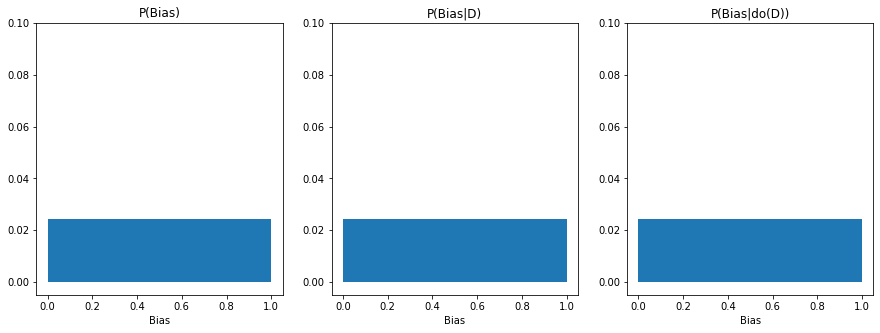

In [49]:
# Prepare the cut forthe data.
observations = ['X_1=1', 'X_2=1', 'X_3=0', 'X_4=1']
cut_data = None
for s in observations:
  if cut_data is None:
    cut_data = bb.prop(s)
  else:
    cut_data &= bb.prop(s)

# Prepare the cut for the query.
cut_query = bb.prop('X_5=1')

# Question 1
bias = bb.rv('Bias')
print('P(Bias) :\n' + str(bias))

# Question 2
bb_cond = bb.see(cut_data)
print('\nP(X_5 = 1 | Data) = ' + str(bb_cond.prob(cut_query)))

# Question 3
bias_cond = bb_cond.rv('Bias')
print('\nP(Bias | Data) :\n' + str(bias_cond))

# Question 4
bb_int = bb.do(cut_data)
print('\nP(X_5 = 1 | do(Data)) = ' + str(bb_int.prob(cut_query)))

# Question 5
bias_int = bb_int.rv('Bias')
print('\nP(Bias | do(Data)) :' + str(bias_int))

# Display distribution over bias.
print('\nDistribution over biases for the three settings:')

fig = plt.figure(figsize=(15, 5))

# Show prior.
plt.subplot(131)
res = bb.rv('Bias')
theta = np.array([theta for _, theta in res], dtype=np.float)
prob = np.array([prob for prob, _ in res])
plt.fill_between(theta, prob, 0)
plt.title('P(Bias)')
plt.ylim([-0.005, 0.1])
plt.xlabel('Bias')

# Show posterior after conditioning.
plt.subplot(132)
res = bb.see(cut).rv('Bias')
theta = np.array([theta for _, theta in res], dtype=np.float)
prob = np.array([prob for prob, _ in res])
plt.fill_between(theta, prob, 0)
plt.title('P(Bias|D)')
plt.ylim([-0.005, 0.1])
plt.xlabel('Bias')

# Show posterior after intervening.
plt.subplot(133)
res = bb.do(cut).rv('Bias')
theta = np.array([theta for _, theta in res], dtype=np.float)
prob = np.array([prob for prob, _ in res])
plt.fill_between(theta, prob, 0)
plt.title('P(Bias|do(D))')
plt.ylim([-0.005, 0.1])
plt.xlabel('Bias')

plt.show()

## Who's in charge?

In this problem we will look at causal induction. Alice and Bob play a game
where both of them shout either 'chicken' or 'egg'.

At the beginning of the game, one of them is chosen to be the leader, and
the other, the follower. The follower will always attempt to match the
leader: so if Alice is the leader and Bob the follower, and Alice
shouts 'chicken', then Bob will attempt to shout 'chicken' too (with
60% success rate).

A typical game would look like this:

-  Round 1: Alice shouts 'egg', Bob shouts 'chicken'.
-  Round 2: Alice shouts 'chicken', Bob shouts 'chicken'.
-  Round 3: Alice shouts 'chicken', Bob shouts 'chicken'.
-  Round 4: Alice shouts 'egg', Bob shouts 'egg'.

Note that you hear both of them shouting simultaneously.

Our goal is to discover who's the leader. This is a **causal induction
problem**, because we want to figure out whether:
-  hypothesis `Leader = Alice`: Alice $\rightarrow$ Bob;
-  or hypothesis `Leader = Bob`: Bob $\rightarrow$ Alice.

Let's start by defining the factory function.

In [50]:
#@title Leader factory function.

def leader(bvar, T=2):
  p = 0.75 # Probability of match.

  # Define leader.
  if 'Leader' not in bvar:
    return [(0.5, 'Leader=Alice'), (0.5, 'Leader=Bob')]

  # Now create the shouts.

  # Figure out the leader.
  if bvar['Leader'] == 'Alice':
    leader = 'Alice'
    follower = 'Bob'
  else:
    leader = 'Bob'
    follower = 'Alice'

  # Define random variables of shouts.
  for t in range(1, T+1):
    leader_str = leader + '_' + str(t)
    if leader_str not in bvar:
      return [(0.5, leader_str + '=chicken'), (0.5, leader_str + '=egg')]

    follower_str = follower + '_' + str(t)
    if follower_str not in bvar:
      if bvar[leader_str] == 'chicken':
        return [(p, follower_str + '=chicken'), (1-p, follower_str + '=egg')]
      else:
        return [(1-p, follower_str + '=chicken'), (p, follower_str + '=egg')]

  # We're done.
  return None

# Create true environment.
class ChickenEggGame:

  def __init__(self, T=2):
    self.T = T
    self.pt = PTree.fromFunc(lambda bvar:leader(bvar, T=T))
    smp = self.pt.sample()
    self.pt.do(self.pt.prop('Leader=' + smp['Leader']))
    self.time = 0

  def step(self, name, word):
    # Check whether parameters are okay.
    if name != 'Alice' and name != 'Bob':
      raise Exception('"name" has to be either "Alice" or "Bob".')
    if word != 'chicken' and word != 'egg':
      raise Exception('"word" has to be either "chicken" or "egg".')
    if self.time > self.T -1:
      raise Exception('The game has only ' + str(self.T) + ' rounds.')

    # Enforce instruction.
    self.time = self.time + 1
    cut_do = self.pt.prop(name + '_' + str(self.time) + '=' + word)
    self.pt = self.pt.do(cut_do)

    # Produce next sample.
    smp = self.pt.sample()
    if name == 'Alice':
      varname = 'Bob_' + str(self.time)
    else:
      varname = 'Alice_' + str(self.time)
    response = smp[varname]
    cut_see = self.pt.prop(varname + '=' + response) 
    self.pt = self.pt.see(cut_see)

    return varname + '=' + response

  def reveal(self):
    smp = self.pt.sample()
    return smp['Leader']

The factory function is called `leader()`.

Let's first have a look at how the probability tree would
look like for `T = 2` rounds.

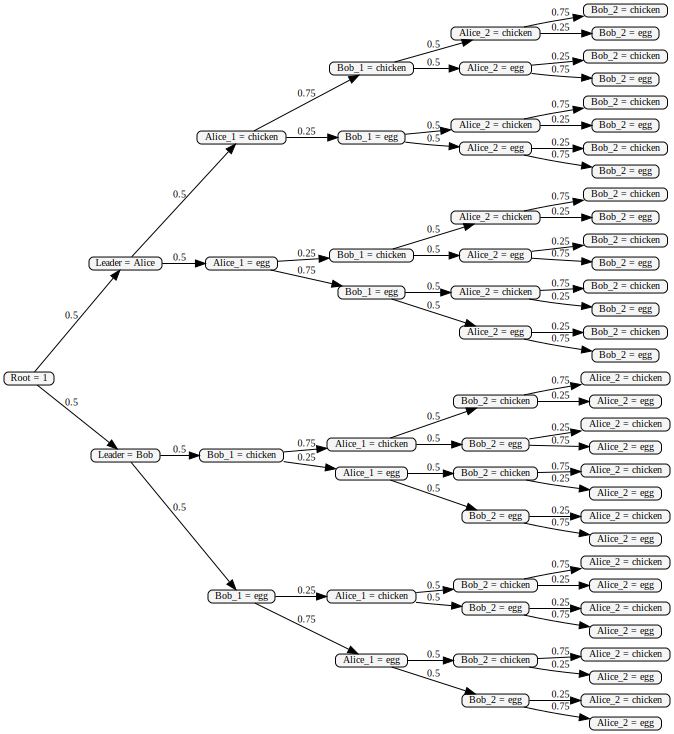

In [51]:
ld = PTree.fromFunc(lambda bvar: leader(bvar, T=2), root_statement='Root = 1')
display(ld.show())

Notice how the transition probabilities of `Alice_n, Bob_n`,
`n = 1, 2`, are identical within the subtree rooted at 
`Leader = Alice`. The same is true for the transitions probabilities
within the subtree rooted at `Leader = Bob`.


Now, let's create a new probability tree for a slightly longer game,
namely `T = 5`. **This tree is too big to display** (over 2K nodes)
but we can still sample from it.

In [52]:
T = 5
ld = PTree.fromFunc(lambda bvar: leader(bvar, T=T), root_statement='Root = 1')

print('Samples from the probability tree:')
for n in range(T):
  print(ld.sample())

Samples from the probability tree:
{'Root': '1', 'Leader': 'Alice', 'Alice_1': 'chicken', 'Bob_1': 'chicken', 'Alice_2': 'egg', 'Bob_2': 'egg', 'Alice_3': 'chicken', 'Bob_3': 'egg', 'Alice_4': 'chicken', 'Bob_4': 'chicken', 'Alice_5': 'egg', 'Bob_5': 'chicken'}
{'Root': '1', 'Leader': 'Alice', 'Alice_1': 'egg', 'Bob_1': 'egg', 'Alice_2': 'chicken', 'Bob_2': 'chicken', 'Alice_3': 'chicken', 'Bob_3': 'chicken', 'Alice_4': 'egg', 'Bob_4': 'chicken', 'Alice_5': 'chicken', 'Bob_5': 'chicken'}
{'Root': '1', 'Leader': 'Alice', 'Alice_1': 'chicken', 'Bob_1': 'chicken', 'Alice_2': 'chicken', 'Bob_2': 'chicken', 'Alice_3': 'chicken', 'Bob_3': 'chicken', 'Alice_4': 'egg', 'Bob_4': 'egg', 'Alice_5': 'chicken', 'Bob_5': 'egg'}
{'Root': '1', 'Leader': 'Alice', 'Alice_1': 'egg', 'Bob_1': 'egg', 'Alice_2': 'egg', 'Bob_2': 'egg', 'Alice_3': 'chicken', 'Bob_3': 'chicken', 'Alice_4': 'chicken', 'Bob_4': 'chicken', 'Alice_5': 'chicken', 'Bob_5': 'chicken'}
{'Root': '1', 'Leader': 'Alice', 'Alice_1': 'egg'

Let's first figure out the joint distribution over Alice's and Bob's shouts
in the first round (remember, rounds are i.i.d.) when Alice is the leader,
and compare this to the situation when Bob is the leader.

We can do this by setting `Leader` to whoever we want to be the leader,
and then enumerate the joint probabilities over the combinations of
shouts.

In [53]:
import itertools

# Define cuts for both leaders.
cut_leader_a = ld.prop('Leader = Alice')
cut_leader_b = ld.prop('Leader = Bob')

# The words they can say.
words = ['chicken', 'egg']

# Print the joint distribution over
# shouts when Alice is the leader.
print('Leader = Alice')
for word_a, word_b in itertools.product(words, words):
  cut = ld.prop('Alice_1 = ' + word_a) & ld.prop('Bob_1 = ' + word_b)
  prob = ld.do(cut_leader_a).prob(cut)
  fmt = 'P( Alice_1 = {}, Bob_1 = {} | Leader <- Alice) = {:.2f}'
  print(fmt.format(word_a, word_b, prob))

# Print the joint distribution over
# shouts when Bob is the leader.
print('\nLeader = Bob')
for word_a, word_b in itertools.product(words, words):
  cut = ld.prop('Alice_1 = ' + word_a) & ld.prop('Bob_1 = ' + word_b)
  prob = ld.do(cut_leader_b).prob(cut)
  fmt = 'P( Alice_1 = {}, Bob_1 = {} | Leader <- Bob) = {:.2f}'
  print(fmt.format(word_a, word_b, prob))

Leader = Alice
P( Alice_1 = chicken, Bob_1 = chicken | Leader <- Alice) = 0.38
P( Alice_1 = chicken, Bob_1 = egg | Leader <- Alice) = 0.12
P( Alice_1 = egg, Bob_1 = chicken | Leader <- Alice) = 0.12
P( Alice_1 = egg, Bob_1 = egg | Leader <- Alice) = 0.38

Leader = Bob
P( Alice_1 = chicken, Bob_1 = chicken | Leader <- Bob) = 0.38
P( Alice_1 = chicken, Bob_1 = egg | Leader <- Bob) = 0.12
P( Alice_1 = egg, Bob_1 = chicken | Leader <- Bob) = 0.12
P( Alice_1 = egg, Bob_1 = egg | Leader <- Bob) = 0.38


Looking at the joint probabilities, **we realize that they are identical**.
This means that we cannot identify who's the leader by conditioning on
our observations. Let's try this with the following observations:
```
obs = [
  'Alice_1=chicken', 'Bob_1=egg', 
  'Alice_2=egg', 'Bob_2=egg', 
  'Alice_3=egg', 'Bob_3=egg'
  ]
```

We now compare the prior and posterior probabilities of Bob being the leader.

In [54]:
import functools 

obs = [
  'Alice_1=chicken', 'Bob_1=egg', 
  'Alice_2=egg', 'Bob_2=egg', 
  'Alice_3=egg', 'Bob_3=egg'
  ]
cuts_data = [ld.prop(data) for data in obs]
cut_data = functools.reduce(lambda x, y: x & y, cuts_data)
cut_query = ld.prop('Leader=Bob')

prob_prior = ld.prob(cut_query)
prob_post = ld.see(cut_data).prob(cut_query)
print('Prior and posterior probabilities:')
print('P( Leader = Bob ) = {:.2f}'.format(prob_prior))
print('P( Leader = Bob | Data ) = {:.2f}'.format(prob_post))


Prior and posterior probabilities:
P( Leader = Bob ) = 0.50
P( Leader = Bob | Data ) = 0.50


As you can see, this doesn't work - we can't disentangle the two hypotheses
just by looking at the data.

Intuitively, we could figure out whether Alice or Bob is the leader by
intervening the game - for instance, by instructing Bob to say what
we want and observe Alice's reaction:
-  if Alice matches Bob many times, then she's probably the follower;
-  instead if Alice does not attempt to match Bob, then we can conclude 
that Alice is the leader.

Crucially, we need to **interact** in order to collect the data. 
It's not enough to passively observe. For this, we'll use
an implementation of the game (`ChickenEggGame`) that allows
us to instruct either Alice or Bob to shout the word we want. 

In [55]:
T = 5
game = ChickenEggGame(T=T)

# Do T rounds.
for n in range(T):
  reply = game.step('Alice', 'chicken')
  print(reply)

# Reveal.
print('The true leader is:' + game.reveal())

Bob_1=chicken
Bob_2=chicken
Bob_3=chicken
Bob_4=chicken
Bob_5=egg
The true leader is:Alice


###  Exercise

Using `ChickenEggGame`, play `T=5` rounds giving an instruction.
Use a copy of the probability tree `ld` to record the results,
appropriately distinguishing between conditions and interventions.
Finally, compute the posterior probability of Alice being the
leader and compare with ground truth (using the `reveal` method).



#### Solution

In [56]:
import copy

T = 5
game = ChickenEggGame(T=T)

# Do T rounds.
print('Game:')
ldg = copy.deepcopy(ld)
for t in range(1, T+1):
  reply = game.step('Alice', 'chicken')
  instruction = 'Alice_' + str(t) + '=chicken'
  ldg = ldg.do(ldg.prop(instruction))
  ldg = ldg.see(ldg.prop(reply))
  print(instruction + ', ' + reply)

# Prediction.
print('\nPrediction:')
cut_query = ldg.prop('Leader=Alice')
prob_post = ldg.prob(cut_query)
print('P(Leader = Alice | Data) = {:.5f}'.format(prob_post))

# Reveal ground truth.
print('\nGround truth:')
print('Leader = ' + game.reveal())

Game:
Alice_1=chicken, Bob_1=chicken
Alice_2=chicken, Bob_2=egg
Alice_3=chicken, Bob_3=egg
Alice_4=chicken, Bob_4=chicken
Alice_5=chicken, Bob_5=chicken

Prediction:
P(Leader = Alice | Data) = 0.45763

Ground truth:
Leader = Bob
